<a href="https://www.kaggle.com/code/kasanagottukumar/alzheimer-s-disease-classification?scriptVersionId=120601110" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Alzheimer's Disease Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import BatchNormalization, MaxPool2D, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.4.1


### Data Pre-Processing

In [2]:
base_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree
(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['VeryMildDemented', 'MildDemented', 'NonDemented', 'ModerateDemented']


In [3]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:


ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500)

Found 5121 images belonging to 4 classes.


In [5]:
train_data, train_labels = train_data_gen.next()

In [6]:

print(train_data.shape, train_labels.shape)

(5121, 176, 176, 3) (5121, 4)


In [7]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(10240, 176, 176, 3) (10240, 4)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Constructing a Convolutional Neural Network Architecture

In [9]:
model = Sequential([
        Input(shape=(*IMAGE_SIZE
                     , 3)),
        Conv2D(16, 3, activation='relu', padding='same'),
        Conv2D(16, 3, activation='relu', padding='same'),
        MaxPool2D(),
        Conv2D(32, 3, activation='relu', padding='same'),
        Conv2D(32, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(),
        Conv2D(64, 3, activation='relu', padding='same'),
        Conv2D(64, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(),
        Conv2D(128, 3, activation='relu', padding='same'),
        Conv2D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(),
        Dropout(0.2),
        Conv2D(256, 3, activation='relu', padding='same'),
        Conv2D(256, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.7),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

In [10]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [11]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 176, 176, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 88, 88, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 88, 88, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 88, 88, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 44, 32)        0 

### Training & Testing the Model

In [12]:
EPOCHS = 30

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/30
205/205 [==============================] - 15s 46ms/step - loss: 1.8524 - acc: 0.2664 - auc: 0.5193 - f1_score: 0.2664 - val_loss: 1.5116 - val_acc: 0.2593 - val_auc: 0.5207 - val_f1_score: 0.1030
Epoch 2/30
205/205 [==============================] - 7s 36ms/step - loss: 1.5603 - acc: 0.2635 - auc: 0.5210 - f1_score: 0.2629 - val_loss: 1.5521 - val_acc: 0.1885 - val_auc: 0.4949 - val_f1_score: 0.1240
Epoch 3/30
205/205 [==============================] - 8s 37ms/step - loss: 1.4334 - acc: 0.3057 - auc: 0.5625 - f1_score: 0.3056 - val_loss: 1.6395 - val_acc: 0.2489 - val_auc: 0.5128 - val_f1_score: 0.0997
Epoch 4/30
205/205 [==============================] - 8s 37ms/step - loss: 1.3535 - acc: 0.3386 - auc: 0.6141 - f1_score: 0.3383 - val_loss: 2.2009 - val_acc: 0.2495 - val_auc: 0.5400 - val_f1_score: 0.1011
Epoch 5/30
205/205 [==============================] - 8s 37ms/step - loss: 1.1011 - acc: 0.4852 - auc: 0.7727 - f1_score: 0.4639 - val_loss: 1.7337 - val_acc: 0.2477 - val

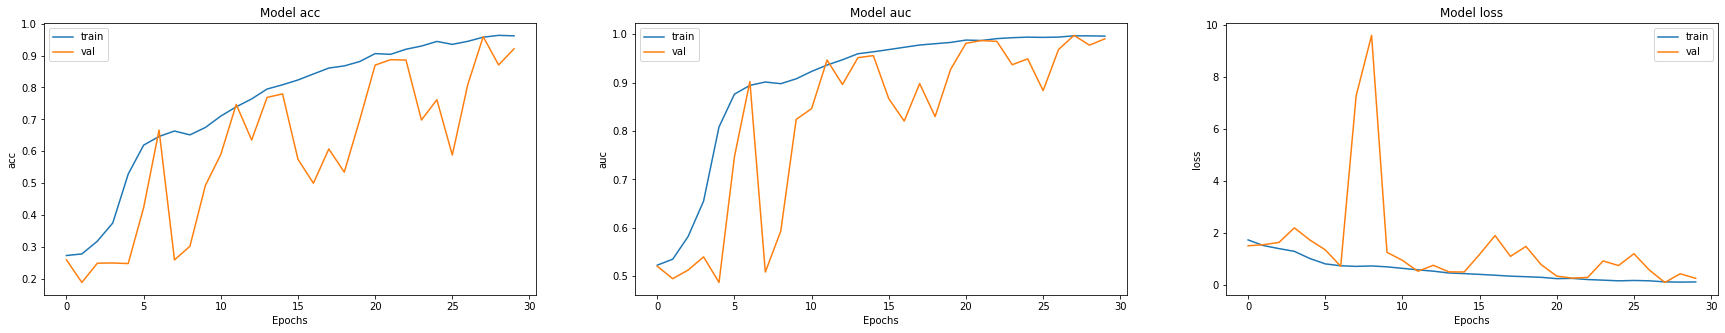

In [13]:

fig, mat = plt.subplots(1, 3, figsize = (30, 5))
mat = mat.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    mat[i].plot(history.history[metric])
    mat[i].plot(history.history["val_" + metric])
    mat[i].set_title("Model {}".format(metric))
    mat[i].set_xlabel("Epochs")
    mat[i].set_ylabel(metric)
    mat[i].legend(["train", "val"])

In [14]:

test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

64/64 [==============================] - 1s 14ms/step - loss: 0.2554 - acc: 0.9126 - auc: 0.9904 - f1_score: 0.9125
Testing Accuracy: 91.26%


In [15]:
pred_labels = model.predict(test_data)

In [16]:

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.98      0.99      0.99       484
VeryMildDemented       1.00      1.00      1.00       520
    MildDemented       0.99      0.69      0.81       528
ModerateDemented       0.75      0.98      0.85       516

       micro avg       0.91      0.91      0.91      2048
       macro avg       0.93      0.91      0.91      2048
    weighted avg       0.93      0.91      0.91      2048
     samples avg       0.91      0.91      0.91      2048



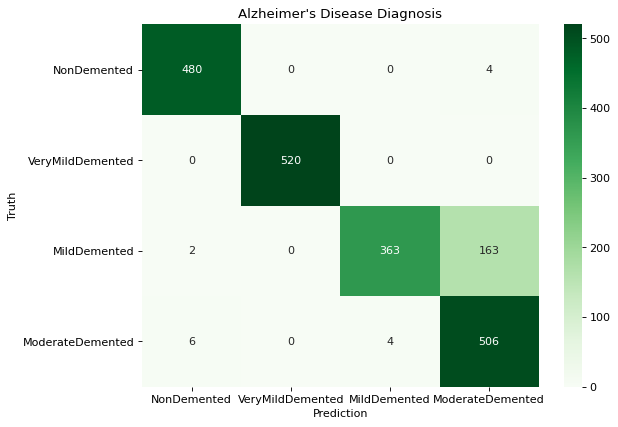

In [17]:

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [18]:

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 91.5 %
Matthew's Correlation Coefficient: 89.07 %


In [19]:

model_dir = work_dir + "alzheimer_cnn_model"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['VeryMildDemented',
 'MildDemented',
 'alzheimer_cnn_model',
 'NonDemented',
 'ModerateDemented']

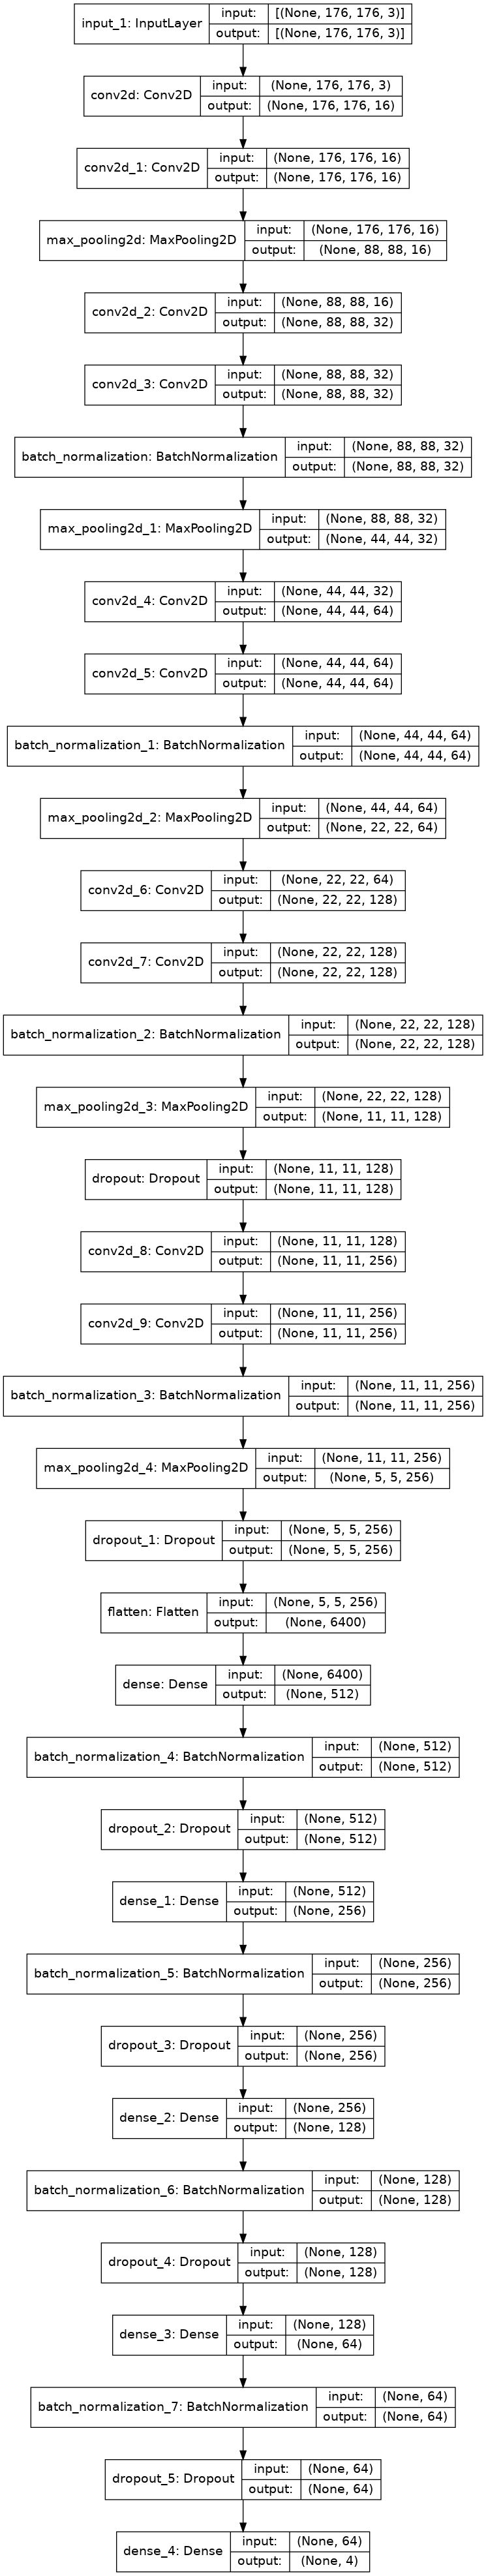

In [20]:
tf.keras.utils.plot_model(model, to_file="cnn_model.png", show_shapes=True)

### Using the InceptionV3 model as a base model for the task

In [21]:
# ivm = Sequential([
#     InceptionResNetV2(input_shape=(176,176,3),include_top=False,weights='imagenet',pooling='same'),
#     MaxPool2D(),
#     Flatten(),
#     Dense(64, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(4,activation='softmax')
# ],name="ivm_model")

In [22]:
# ivm.compile( optimizer='adam',loss='categorical_crossentropy',metrics= METRICS)

# ivm.summary()

In [23]:

# EPOCHS = 30

# history_ivm = ivm.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

In [24]:


# fig, mat = plt.subplots(1, 3, figsize = (30, 5))
# mat = mat.ravel()

# for i, metric in enumerate(["acc", "auc", "loss"]):
#     mat[i].plot(history_ivm.history[metric])
#     mat[i].plot(history_ivm.history["val_" + metric])
#     mat[i].set_title("Model {}".format(metric))
#     mat[i].set_xlabel("Epochs")
#     mat[i].set_ylabel(metric)
#     mat[i].legend(["train", "val"])

In [25]:
# test_scores = ivm.evaluate(test_data, test_labels)

# print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

In [26]:
# pred_labels = ivm.predict(test_data)

In [27]:

# def roundoff(arr):
#     arr[np.argwhere(arr != arr.max())] = 0
#     arr[np.argwhere(arr == arr.max())] = 1
#     return arr

# for labels in pred_labels:
#     labels = roundoff(labels)

# print(classification_report(test_labels, pred_labels, target_names=CLASSES))

In [28]:


# pred_ls = np.argmax(pred_labels, axis=1)
# test_ls = np.argmax(test_labels, axis=1)

# conf_arr = confusion_matrix(test_ls, pred_ls)

# plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

# ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

# plt.title('Alzheimer\'s Disease Diagnosis using InceptionResnetV2')
# plt.xlabel('Prediction')
# plt.ylabel('Truth')
# plt.show(ax)

In [29]:
# print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
# print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

In [30]:
# model_dir2 = work_dir + "alzheimer_inceptionresnet"
# model.save(model_dir2, save_format='h5')
# os.listdir(work_dir)

In [31]:
# tf.keras.utils.plot_model(ivm, to_file="res_model.png", show_shapes=True)

#  **Using DenseNet 169**

In [32]:
dnm =  Sequential(
        [DenseNet169(input_shape=(176,176,3),include_top=False,weights='imagenet',pooling='same'),
        MaxPool2D(),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3), 
        Dense(4,activation='softmax')
        ],name="dense_model")



51879936/51877672 [==============================] - 2s 0us/step


In [33]:
dnm.compile( optimizer='adam',loss='categorical_crossentropy',metrics= METRICS)

dnm.summary()

Model: "dense_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 5, 5, 1664)        12642880  
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 1664)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6656)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               852096    
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 

In [34]:

EPOCHS = 30

history_dnm = dnm.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/30
205/205 [==============================] - 59s 206ms/step - loss: 0.8400 - acc: 0.7908 - auc: 0.9549 - f1_score: 0.7895 - val_loss: 0.9111 - val_acc: 0.6754 - val_auc: 0.8906 - val_f1_score: 0.6579
Epoch 2/30
205/205 [==============================] - 37s 181ms/step - loss: 0.2713 - acc: 0.8951 - auc: 0.9861 - f1_score: 0.8936 - val_loss: 0.5726 - val_acc: 0.7791 - val_auc: 0.9492 - val_f1_score: 0.7848
Epoch 3/30
205/205 [==============================] - 37s 182ms/step - loss: 0.1541 - acc: 0.9472 - auc: 0.9950 - f1_score: 0.9476 - val_loss: 1.2525 - val_acc: 0.6638 - val_auc: 0.8807 - val_f1_score: 0.6165
Epoch 4/30
205/205 [==============================] - 37s 180ms/step - loss: 0.1097 - acc: 0.9596 - auc: 0.9977 - f1_score: 0.9598 - val_loss: 2.1706 - val_acc: 0.6852 - val_auc: 0.8418 - val_f1_score: 0.5990
Epoch 5/30
205/205 [==============================] - 37s 179ms/step - loss: 0.0777 - acc: 0.9719 - auc: 0.9987 - f1_score: 0.9715 - val_loss: 0.4796 - val_acc: 0.8

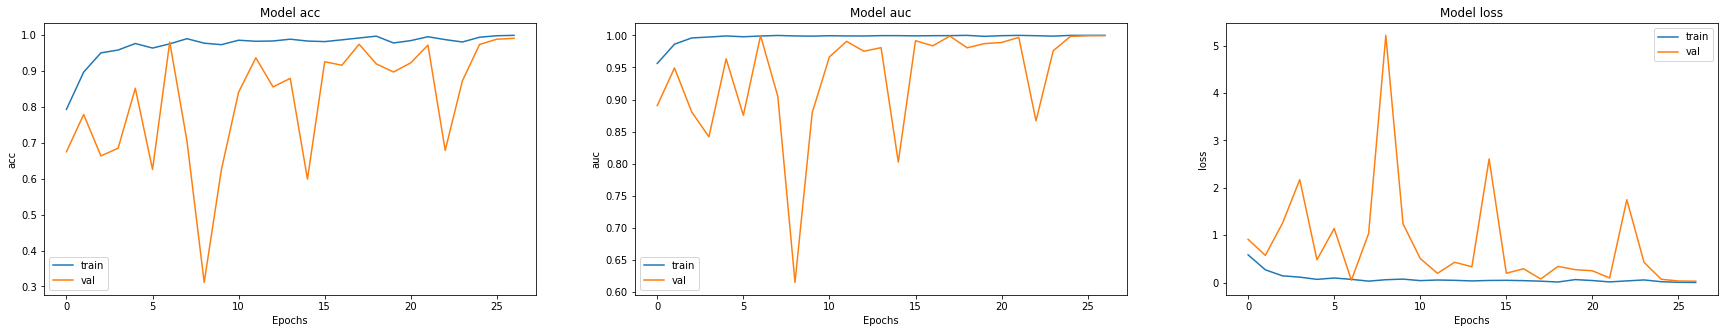

In [35]:

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history_dnm.history[metric])
    ax[i].plot(history_dnm.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [36]:
test_scores = dnm.evaluate(test_data, test_labels)

print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

64/64 [==============================] - 6s 56ms/step - loss: 0.0302 - acc: 0.9927 - auc: 0.9991 - f1_score: 0.9927
Testing Accuracy: 99.27%


In [37]:
pred_labels = dnm.predict(test_data)

In [38]:

def roundoff(arr):
    
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.99      1.00      0.99       484
VeryMildDemented       1.00      1.00      1.00       520
    MildDemented       1.00      0.97      0.99       528
ModerateDemented       0.98      1.00      0.99       516

       micro avg       0.99      0.99      0.99      2048
       macro avg       0.99      0.99      0.99      2048
    weighted avg       0.99      0.99      0.99      2048
     samples avg       0.99      0.99      0.99      2048



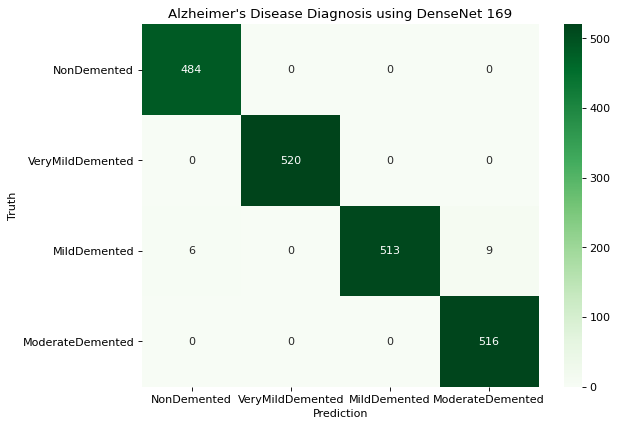

In [39]:


pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis using DenseNet 169')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [40]:

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 99.29 %
Matthew's Correlation Coefficient: 99.03 %


In [41]:
model_dir = work_dir + "alzheimer_densenet"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['VeryMildDemented',
 'MildDemented',
 'alzheimer_cnn_model',
 'NonDemented',
 'ModerateDemented',
 'alzheimer_densenet']

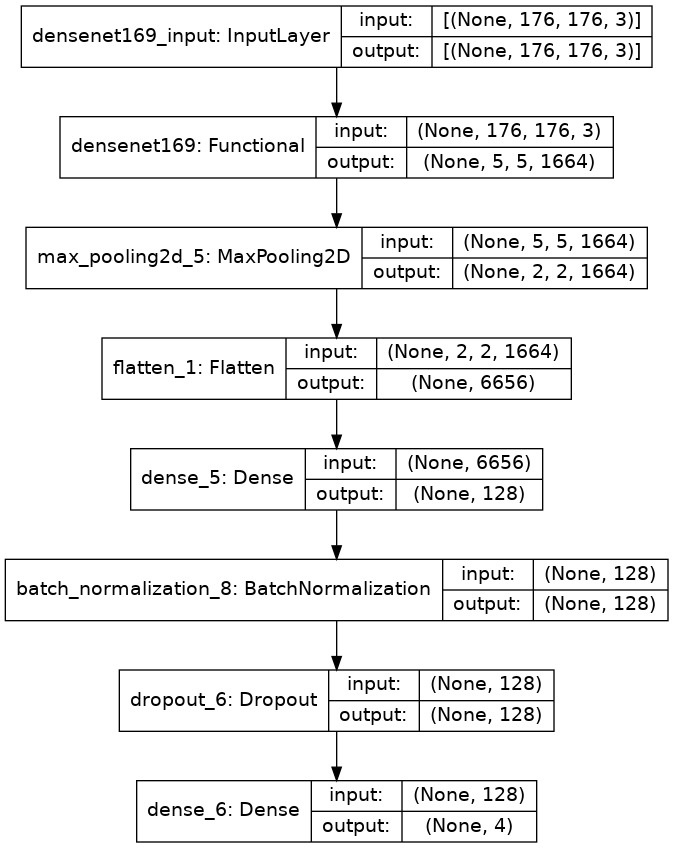

In [42]:
tf.keras.utils.plot_model(dnm, to_file="dnm_model.png", show_shapes=True)

# Using ResNet50V2

In [43]:
rnm =  Sequential([
    ResNet50V2(input_shape=(176,176,3),include_top=False,weights='imagenet',pooling='same'),
    MaxPool2D(),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3), 
    Dense(4,activation='softmax')],name="rnm_model")


94674944/94668760 [==============================] - 3s 0us/step


In [44]:
rnm.compile( optimizer='adam',loss='categorical_crossentropy',metrics= METRICS)

rnm.summary()

Model: "rnm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 6, 6, 2048)        23564800  
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               4718848   
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 10

In [45]:

EPOCHS = 30

history_rnm = rnm.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/30
205/205 [==============================] - 35s 137ms/step - loss: 0.8995 - acc: 0.8277 - auc: 0.9667 - f1_score: 0.8271 - val_loss: 2.2914 - val_acc: 0.6376 - val_auc: 0.8278 - val_f1_score: 0.5520
Epoch 2/30
205/205 [==============================] - 26s 125ms/step - loss: 0.2184 - acc: 0.9225 - auc: 0.9902 - f1_score: 0.9224 - val_loss: 1.7849 - val_acc: 0.6113 - val_auc: 0.8358 - val_f1_score: 0.5500
Epoch 3/30
205/205 [==============================] - 26s 125ms/step - loss: 0.1365 - acc: 0.9509 - auc: 0.9959 - f1_score: 0.9503 - val_loss: 0.6014 - val_acc: 0.8005 - val_auc: 0.9554 - val_f1_score: 0.7873
Epoch 4/30
205/205 [==============================] - 26s 125ms/step - loss: 0.0793 - acc: 0.9700 - auc: 0.9987 - f1_score: 0.9702 - val_loss: 3.6549 - val_acc: 0.4088 - val_auc: 0.6929 - val_f1_score: 0.3405
Epoch 5/30
205/205 [==============================] - 25s 124ms/step - loss: 0.0647 - acc: 0.9762 - auc: 0.9990 - f1_score: 0.9766 - val_loss: 0.6885 - val_acc: 0.7

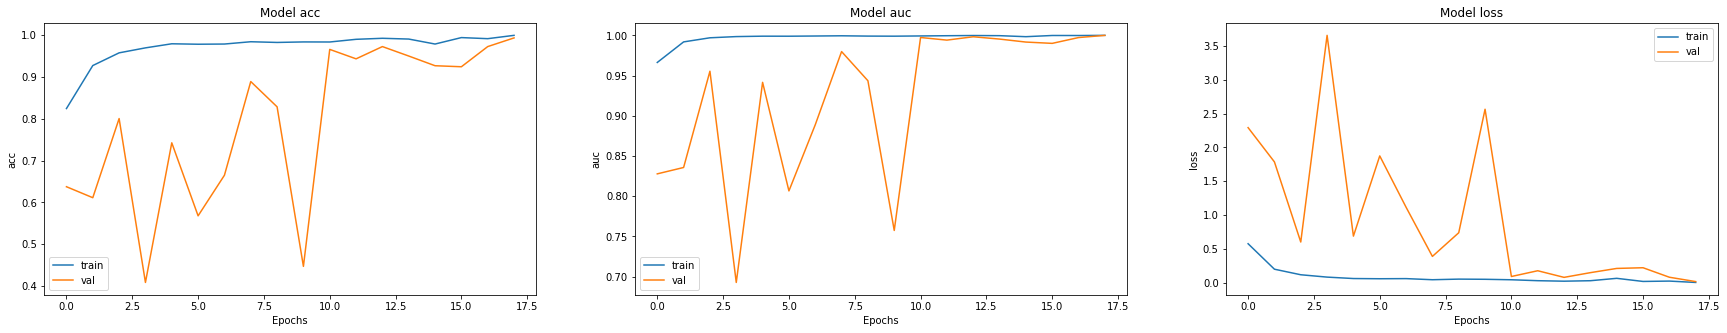

In [46]:


fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history_rnm.history[metric])
    ax[i].plot(history_rnm.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [47]:
test_scores = rnm.evaluate(test_data, test_labels)

print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

64/64 [==============================] - 4s 42ms/step - loss: 0.0166 - acc: 0.9946 - auc: 0.9996 - f1_score: 0.9947
Testing Accuracy: 99.46%


In [48]:
pred_labels = rnm.predict(test_data)

In [49]:

def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       1.00      1.00      1.00       484
VeryMildDemented       1.00      1.00      1.00       520
    MildDemented       0.99      0.99      0.99       528
ModerateDemented       0.99      0.99      0.99       516

       micro avg       0.99      0.99      0.99      2048
       macro avg       0.99      0.99      0.99      2048
    weighted avg       0.99      0.99      0.99      2048
     samples avg       0.99      0.99      0.99      2048



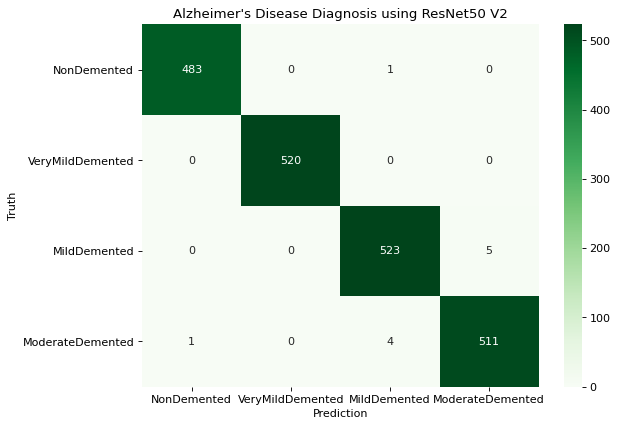

In [50]:


pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis using ResNet50 V2')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [51]:

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 99.47 %
Matthew's Correlation Coefficient: 99.28 %


In [52]:
model_dir = work_dir + "alzheimer_resnet50V2"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['VeryMildDemented',
 'MildDemented',
 'alzheimer_resnet50V2',
 'alzheimer_cnn_model',
 'NonDemented',
 'ModerateDemented',
 'alzheimer_densenet']

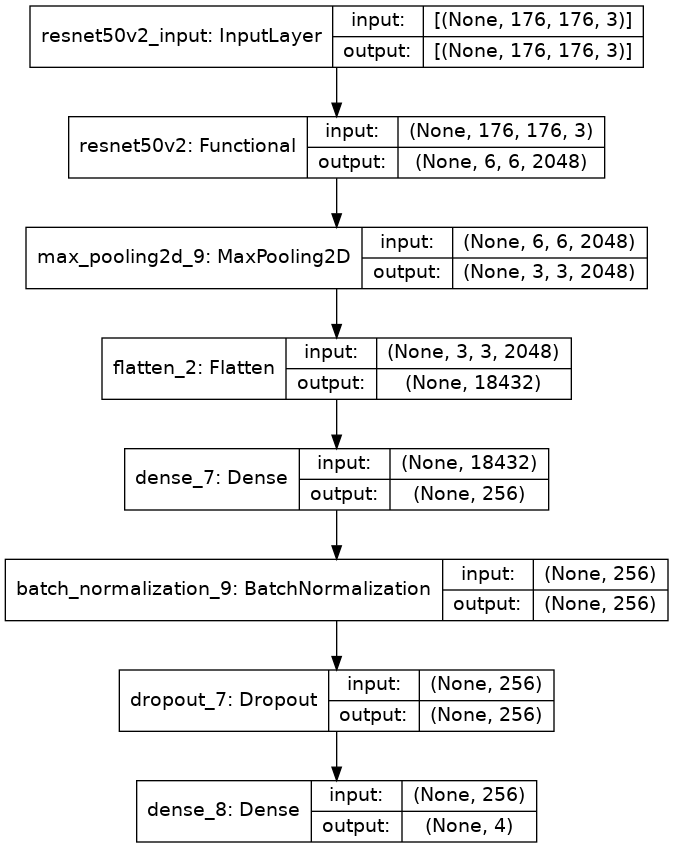

In [53]:
tf.keras.utils.plot_model(rnm, to_file="rnm_model.png", show_shapes=True)